# Detecção de fraude em transações de cartões de crédito utilizando modelos classificatórios de Machine Learning (KNN)



In [70]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_validate, KFold

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Análise exploratória

Os datasets utilizados neste trabalho foram obtidos [dessa base de dados do Kaggle](https://www.kaggle.com/datasets/kartik2112/fraud-detection). Dessa forma, eles já estão originalmente separados entre as bases de treino e teste que iremos utilizar.

**Sobre o dataset:** *este é um dataset simulado de transações de cartões de crédito ocorridas entre as datas de 01/01/2019 a 31/12/2020; refere-se aos cartões de 1000 clientes diferentes realizando transações a 800 comerciantes distintos.*

In [2]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/santander-coders-2023/projetos/ml1/fraudTrain.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/santander-coders-2023/projetos/ml1/fraudTest.csv")

In [3]:
# Quantidade de dados em cada dataframe:

print(f"Treino: {df_train.shape}")
print(f"Teste: {df_test.shape}")

t_linhas = len(df_train)+len(df_test)
print(f"Quantidade de linhas totais: {t_linhas}")

Treino: (1296675, 23)
Teste: (555719, 23)
Quantidade de linhas totais: 1852394


In [4]:
# Proporcionalmente:

print(f"df_train: {round((len(df_train)*100)/t_linhas,2)}%")
print(f"df_test: {round((len(df_test)*100)/t_linhas,2)}%")

df_train: 70.0%
df_test: 30.0%


## 1.1. Descrição geral dos dataframes

In [5]:
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [8]:
# Dropando colunas desnecessárias:

df_train.drop(columns = "Unnamed: 0", inplace = True)
df_test.drop(columns = "Unnamed: 0", inplace = True)

Verificando a existência de valores nulos:

In [9]:
df_train.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [10]:
df_test.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Observe que os dados de treino foram selecionados entre as datas de `2019-01-01 00:00:18` e `2020-06-21 12:13:37`. As transações realizados a posteriori serão utilizadas como teste.

In [11]:
# Convertendo as colunas de data

df_train["trans_date_trans_time"] = pd.to_datetime(df_train["trans_date_trans_time"], yearfirst=True)
df_test["trans_date_trans_time"] = pd.to_datetime(df_test["trans_date_trans_time"], yearfirst=True)

In [12]:
df_train["trans_date_trans_time"].sort_values()

0         2019-01-01 00:00:18
1         2019-01-01 00:00:44
2         2019-01-01 00:00:51
3         2019-01-01 00:01:16
4         2019-01-01 00:03:06
                  ...        
1296670   2020-06-21 12:12:08
1296671   2020-06-21 12:12:19
1296672   2020-06-21 12:12:32
1296673   2020-06-21 12:13:36
1296674   2020-06-21 12:13:37
Name: trans_date_trans_time, Length: 1296675, dtype: datetime64[ns]

In [13]:
df_test["trans_date_trans_time"].sort_values()

0        2020-06-21 12:14:25
1        2020-06-21 12:14:33
2        2020-06-21 12:14:53
3        2020-06-21 12:15:15
4        2020-06-21 12:15:17
                 ...        
555714   2020-12-31 23:59:07
555715   2020-12-31 23:59:09
555716   2020-12-31 23:59:15
555717   2020-12-31 23:59:24
555718   2020-12-31 23:59:34
Name: trans_date_trans_time, Length: 555719, dtype: datetime64[ns]

## 1.2. Verificando a proporcionalidade dos dados

In [14]:
df_train["is_fraud"].value_counts(normalize=True)*100

0    99.421135
1     0.578865
Name: is_fraud, dtype: float64

In [15]:
df_test["is_fraud"].value_counts(normalize=True)*100

0    99.614014
1     0.385986
Name: is_fraud, dtype: float64

Plotando em termos de quantidade para o dataframe de treino:

<Axes: title={'center': 'Quantidade de dados fraudulentos no dataset de treino'}, xlabel='Fraude', ylabel='Quantidade (10^6)'>

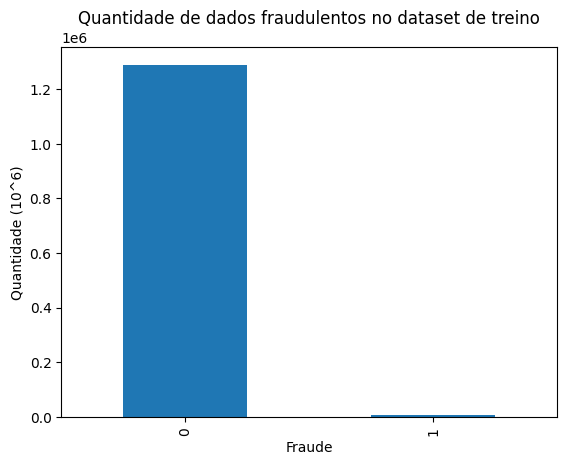

In [16]:
df_train["is_fraud"].value_counts().plot(kind="bar",
                                         xlabel="Fraude",
                                         ylabel="Quantidade (10^6)",
                                         title="Quantidade de dados fraudulentos no dataset de treino")

## 1.3. Analisando e adicionando novas features

In [17]:
df_train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

Nossas colunas de interesse serão:
* `trans_date_trans_time`: data e hora da transação
* `cc_num`: número do cartão de crédito
* `category`: categoria de compra
* `amt`: valor da transação
* `first`: primeiro nome da pessoa
* `last`: último nome da pessoa
* `gender`: gênero da pessoa que realizou a transação
* `dob`: data de nascimento da pessoa que realizou a transação
* `city`: cidade da pessoa que realizou a transação
* `city_pop`: população da cidade da pessoa que realizou a transação
* `lat`: latitude da pessoa que realizou a transação
* `long`: longitude da pessoa que realizou a transação
* `merch_lat`: latitude do comerciante
* `merch_long`: longitude do comerciante
* `is_fraud`: 1 para transações fraudulentas, 0 caso contrário

### 1.3.1. Data e hora

Verificando se existe uma tendência maior no número de fraudes a depender do mês:

<Axes: title={'center': 'Distribuição de frequências para os meses do ano para transações fraudulentas'}, ylabel='Frequency'>

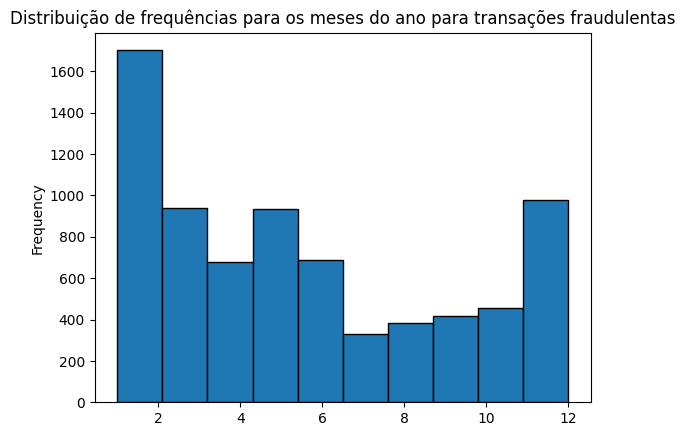

In [18]:
f_is_fraud = df_train["is_fraud"] == 1
f_month = df_train[f_is_fraud]["trans_date_trans_time"].dt.month
f_month.plot(kind="hist",
             edgecolor="black",
             title="Distribuição de frequências para os meses do ano para transações fraudulentas")

In [19]:
f_month.value_counts(ascending=False, normalize=True)*100

3     12.496669
5     12.456701
2     11.364242
1     11.310951
6      9.166001
4      9.032774
12     7.887024
10     6.048495
9      5.568878
11     5.169198
8      5.089262
7      4.409805
Name: trans_date_trans_time, dtype: float64

Nota-se que quase 50% das transações fraudulentas está concentrada em 1/3 dos meses do ano, referentes aos meses 1, 2, 3 e 5.

In [20]:
(f_month.value_counts(ascending=False, normalize=True)*100)[0:4].sum()

47.62856381561418

Verificando se existe uma tendência maior no número de fraudes a depender do dia do mês:

<Axes: title={'center': 'Distribuição de frequências para os dias do mês para transações fraudulentas'}, ylabel='Frequency'>

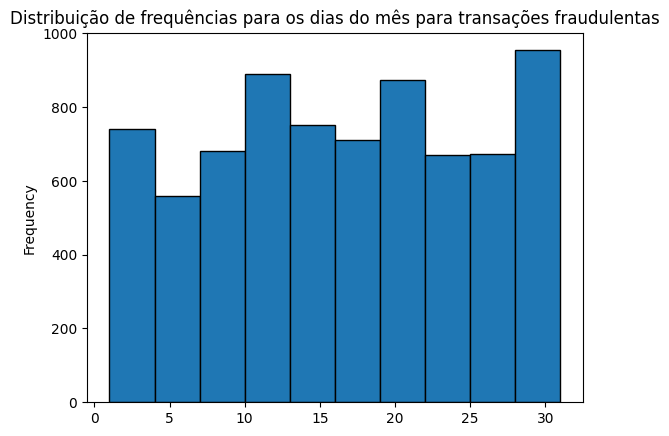

In [21]:
df_train[f_is_fraud]["trans_date_trans_time"].dt.day.plot(kind="hist",
                                                          edgecolor="black",
                                                          title="Distribuição de frequências para os dias do mês para transações fraudulentas")

Não houve diferença significativa nas distribuições.

Verificando se existe uma tendência maior no número de fraudes a depender do dia da semana:

<Axes: title={'center': 'Distribuição de frequências para os dias da semana para transações fraudulentas'}, ylabel='Frequency'>

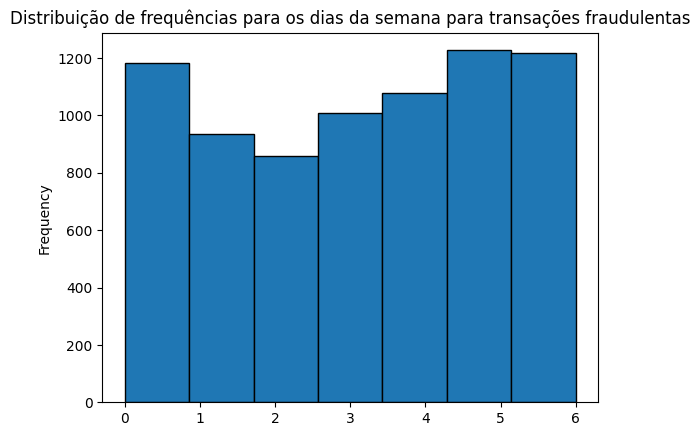

In [22]:
df_train[f_is_fraud]["trans_date_trans_time"].dt.dayofweek.plot(kind="hist",
                                                                edgecolor="black",
                                                                bins=7,
                                                                title="Distribuição de frequências para os dias da semana para transações fraudulentas")

Não houve diferença significativa nas distribuições.

Verificando se existe uma tendência maior no número de fraudes a depender da hora do dia:

<Axes: title={'center': 'Distribuição de frequências para as horas do dia para transações fraudulentas'}, ylabel='Frequency'>

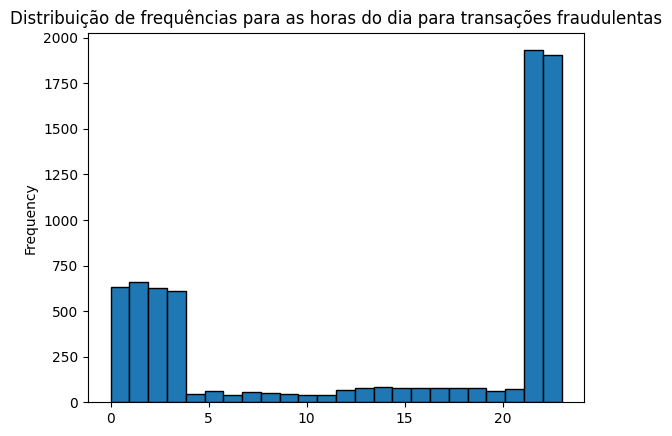

In [23]:
f_hours = df_train[f_is_fraud]["trans_date_trans_time"].dt.hour
f_hours.plot(kind="hist",
             edgecolor="black",
             bins=24,
             title="Distribuição de frequências para as horas do dia para transações fraudulentas")

Nota-se que existe uma clara tendência para que as transações fraudulentas ocorram em horários entre 21:00 e 5:00.

Dessa forma, observamos uma indicação de que as transções fraudulentas tendem a ocorrer em:
* Meses 1, 2, 3 e 5
* Horários entre 21:00 e 5:00

Vamos adicionar uma coluna de flag para essas informações em nossos dataframes:

In [24]:
# Adicionando uma coluna de mês:
df_train["month"] = df_train["trans_date_trans_time"].dt.month
df_test["month"] = df_test["trans_date_trans_time"].dt.month

# Flag de mês:
flag_month = lambda m: 1 if m in [1,2,3,5] else 0
df_train["flag_month"] = df_train["trans_date_trans_time"].dt.month.apply(flag_month)
df_test["flag_month"] = df_test["trans_date_trans_time"].dt.month.apply(flag_month)

# Adicionando uma coluna de horário:
df_train["hour"] = df_train["trans_date_trans_time"].dt.hour
df_test["hour"] = df_test["trans_date_trans_time"].dt.hour

# Flag de horário:
flag_hour = lambda h: 1 if ((h > 21) or (h < 5)) else 0
df_train["flag_hour"] = df_train["trans_date_trans_time"].dt.hour.apply(flag_hour)
df_test["flag_hour"] = df_test["trans_date_trans_time"].dt.hour.apply(flag_hour)

### 1.3.2. Frequência de utilização do cartão de crédito

Vamos analisar se as transações fraudulentas estão vindo dos mesmos cartões.

In [25]:
# Contando a quantidade de vezes que cada cartão fraudou uma transação
df_train[f_is_fraud]["cc_num"].value_counts(ascending=False)

4593569795412          19
3520550088202337       19
4260128500325          18
4400011257587661852    16
3518669219150142       16
                       ..
4503101193493052864     2
4089096483689733451     2
6011109736646996        2
4809701904914           2
4005676619255478        2
Name: cc_num, Length: 762, dtype: int64

Vemos que de fato existe uma tendência para que alguns cartões fraudem mais que as outros. Para identificar isso em nosso dataframe, vamos adicionar uma flag que conta a quantidade de vezes que um determinado cartão realizou uma transação nos últimos 1, 7 e 30 dias.

In [26]:
# Antes, vamos ordenar nossos dataframes por número do cartão e data de transação:

df_train.sort_values(by=["cc_num", "trans_date_trans_time"], inplace=True)

In [27]:
def last1DayTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_1_day').sort_index()
    count_1_day = temp.rolling('1d').count() - 1
    count_1_day.index = temp.values
    x['count_1_day'] = count_1_day.reindex(x.index)
    return x


def last7DaysTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_7_days').sort_index()
    count_7_days = temp.rolling('7d').count() - 1
    count_7_days.index = temp.values
    x['count_7_days'] = count_7_days.reindex(x.index)
    return x


def last30DaysTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_30_days').sort_index()
    count_30_days = temp.rolling('30d').count() - 1
    count_30_days.index = temp.values
    x['count_30_days'] = count_30_days.reindex(x.index)
    return x


# Criando as colunas no dataframe de treino:
df_train = df_train.groupby('cc_num').apply(last1DayTransactionCount)
df_train = df_train.groupby('cc_num').apply(last7DaysTransactionCount)
df_train = df_train.groupby('cc_num').apply(last30DaysTransactionCount)

# Criando as colunas no dataframe de teste:
df_test = df_test.groupby('cc_num').apply(last1DayTransactionCount)
df_test = df_test.groupby('cc_num').apply(last7DaysTransactionCount)
df_test = df_test.groupby('cc_num').apply(last30DaysTransactionCount)

Vamos adicionar também uma coluna que calcula o tempo, em segundos, entre utilizações consecultivas de um cartão de crédito:

In [28]:
def timeDifference(x):
    x["time_diff"] = x.trans_date_trans_time - x.trans_date_trans_time.shift()
    x["time_diff"] = x["time_diff"].dt.seconds
    return x


# Aplicando nos datasets:
df_train = df_train.groupby('cc_num').apply(timeDifference)
df_test = df_test.groupby('cc_num').apply(timeDifference)

Observamos que existe uma tendência para transações fraudulentas ocorrerem em intervalos de tempo curtos:

Text(0, 0.5, 'Frequência')

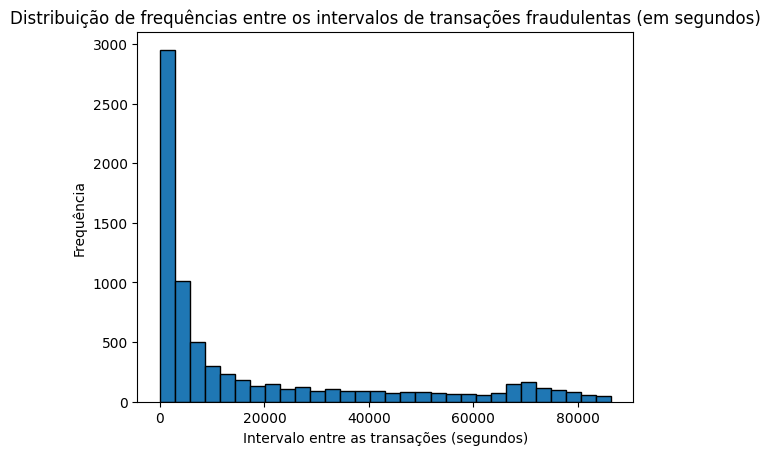

In [29]:
df_train[f_is_fraud]["time_diff"].plot(kind="hist",
                                       edgecolor="black",
                                       bins=30,
                                       title="Distribuição de frequências entre os intervalos de transações fraudulentas (em segundos)")

plt.xlabel("Intervalo entre as transações (segundos)")
plt.ylabel("Frequência")

Existem algumas colunas de `time_diff` que ficaram nulas devido ao fato de que não existem transações consecultivas para determinados números de cartão de crédito. Dessa forma, iremos completa-las com 0.

In [30]:
print(df_train["time_diff"].isnull().sum())
print(df_test["time_diff"].isnull().sum())

983
924


In [31]:
# Completando valores nulos:

df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

### 1.3.3. Categoria de compra

<Axes: title={'center': 'Categoriais de comércio nos quais houveram transações fraudulentas'}, xlabel='Categoria', ylabel='Quantidade de transações'>

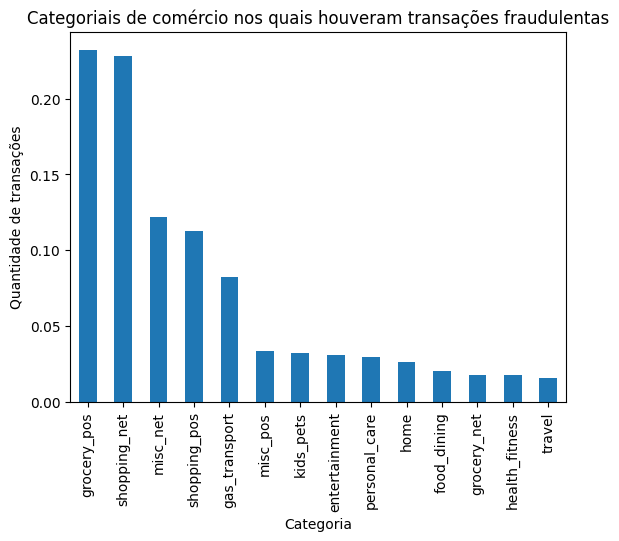

In [32]:
f_category = df_train[f_is_fraud]["category"].value_counts(ascending=False,
                                                           normalize=True)
f_category.plot(kind="bar",
                title="Categoriais de comércio nos quais houveram transações fraudulentas",
                xlabel="Categoria",
                ylabel="Quantidade de transações")

Vemos que as transações fraudulentas ocorrem mais para algumas catergorias específicas de compra. Vamos então transforma-las em variáveis numéricas em nossos datasets.

In [33]:
df_train = pd.get_dummies(df_train, columns=["category"], prefix="category")
df_test = pd.get_dummies(df_test, columns=["category"], prefix="category")

### 1.3.4. Valor da transação

<Axes: ylabel='Frequency'>

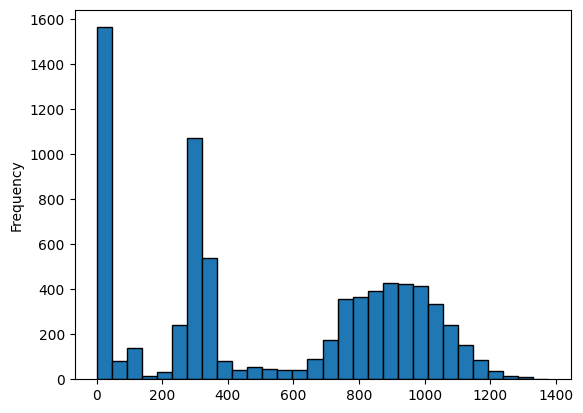

In [34]:
df_train[f_is_fraud]["amt"].plot(kind="hist",
                                 edgecolor="black",
                                 bins=30)

Observamos que realmente a frequência de transações fraudulentas é mais alta para alguns valores específicos.

### 1.3.5. Gênero

In [35]:
df_train[f_is_fraud]["gender"].value_counts(normalize=True)

M    0.502398
F    0.497602
Name: gender, dtype: float64

Ao que indica, não existe uma tendência a relações fraudulentas estarem relacionadas ao gênero da pessoa.

Entretanto, vamos manter essa feature em nosso modelo:

In [36]:
df_train = pd.get_dummies(df_train, columns=["gender"], prefix="gender")
df_test = pd.get_dummies(df_test, columns=["gender"], prefix="gender")

### 1.3.6. Idade

In [37]:
# Convertendo a coluna "dob" para datetime:
df_train["dob"] = pd.to_datetime(df_train["dob"])
df_test["dob"] = pd.to_datetime(df_test["dob"])

# Calculando a idade da pessoa no momento da transação:
df_train["age"] = (df_train["trans_date_trans_time"] - df_train["dob"]).dt.days//365
df_test["age"] = (df_test["trans_date_trans_time"] - df_test["dob"]).dt.days//365

<Axes: ylabel='Frequency'>

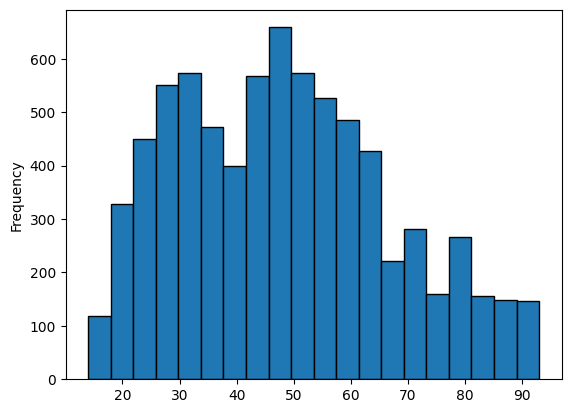

In [38]:
df_train[f_is_fraud]["age"].plot(kind="hist",
                                 bins=20,
                                 edgecolor="black")

Observamos uma menor frequência de transações fraudulentas ocorrendo em pessoas acima de 65 anos e abaixo de 20.

### 1.3.7. Distância

Vamos verificar se a distância ($d$) entre o local de residência da pessoa ($P_a$) e o local de uso do cartão ($P_b$) está relacionado com a quantidade de transações fraudulentas. Para isso, precisamos calcular a distância geográfica ($d$) em graus utilizando coordenadas esféricas.

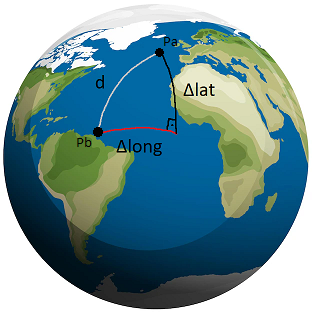

$$\cos(d) = \cos(\Delta lat) \cos(\Delta long) + \sin(\Delta lat) \sin(\Delta long) \cos(90°)$$
$$\implies \cos(d) = \cos(\Delta lat) \cos(\Delta long)$$
$$\implies d = \cos^{-1}[\cos(\Delta lat) \cos(\Delta long)]$$

In [39]:
def calc_d(lat, long, merch_lat, merch_long):
  delta_lat = lat - merch_lat
  delta_long = long - merch_long
  d = np.rad2deg(np.arccos(np.cos(np.deg2rad(delta_lat)) * np.cos(np.deg2rad(delta_long))))
  return d

df_train["distance_pm"] = calc_d(df_train["lat"],
                                 df_train["long"],
                                 df_train["merch_lat"],
                                 df_train["merch_long"])

df_test["distance_pm"] = calc_d(df_test["lat"],
                                df_test["long"],
                                df_test["merch_lat"],
                                df_test["merch_long"])

Verificando a distribuição de distâncias para transações fraudulentas:

Text(0, 0.5, 'Frequência')

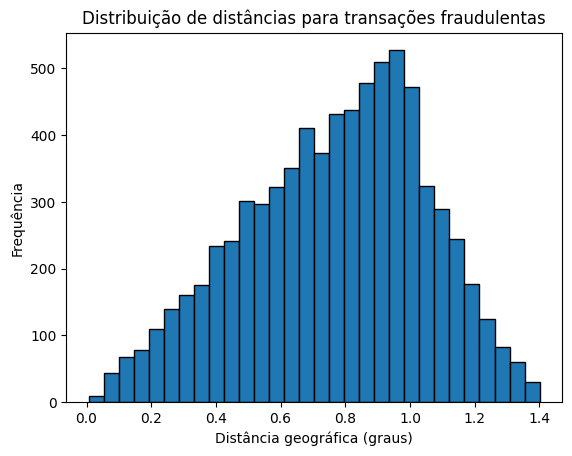

In [40]:
df_train[f_is_fraud]["distance_pm"].plot(kind="hist",
                                         edgecolor="black",
                                         bins=30,
                                         title="Distribuição de distâncias para transações fraudulentas")

plt.xlabel("Distância geográfica (graus)")
plt.ylabel("Frequência")

De fato, observamos uma maior frequência para transações fraudulentas em um certo intervalo de distâncias. Entretanto, ao que parece, essa distribuição está de acordo com a distribuição de transações gerais:

Text(0, 0.5, 'Frequência')

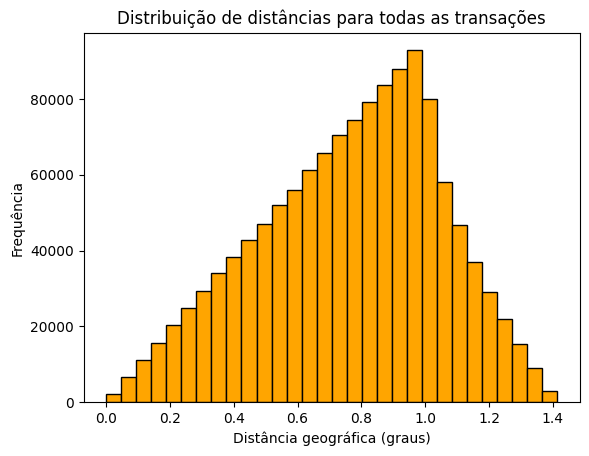

In [41]:
df_train["distance_pm"].plot(kind="hist",
                             edgecolor="black",
                             bins=30,
                             color="orange",
                             title="Distribuição de distâncias para todas as transações")

plt.xlabel("Distância geográfica (graus)")
plt.ylabel("Frequência")

De toda forma, iremos manter essa feature em nosso modelo.

### 1.3.8. Localicade

Cidades de onde saem transações fraudulentas e a quantidade de vezes em que isso ocorre:

In [42]:
f_cities = df_train[f_is_fraud]["city"].value_counts().sort_index()
f_cities.shape

(702,)

Vamos estabelecer a seguinte relação:

$$\frac{Número\ de\  transações\ fraudulentas}{População\ média}$$

In [43]:
# Obtendo a população média das cidades
city_pop_mean = df_train[["city", "city_pop"]].groupby("city").mean().sort_values(by="city")
city_pop_mean.reset_index(inplace=True)

# Filtrando as cidades onde houveram fraudes:
filtro_cidades_fraudulentas = city_pop_mean["city"].apply(lambda c: c in f_cities.index)

# Razão entre o número de transações fraudulentas e a população da cidade
fraud_pop_ratio = f_cities.values/city_pop_mean[filtro_cidades_fraudulentas].city_pop
fraud_pop_ratio = pd.Series(data=fraud_pop_ratio.values, index=f_cities.index)

# Vamos salvar as 50 cidades com o maior índice de fraude por população média
fraud_pop_ratio100 = fraud_pop_ratio.sort_values(ascending=False)[:51]

Vamos agora visualizar as as 50 cidades com o maior índice de fraude por população média:

<Axes: title={'center': 'Razão de fraude por população média (50 maiores maiores cidades)'}, xlabel='Cidades', ylabel='Razão'>

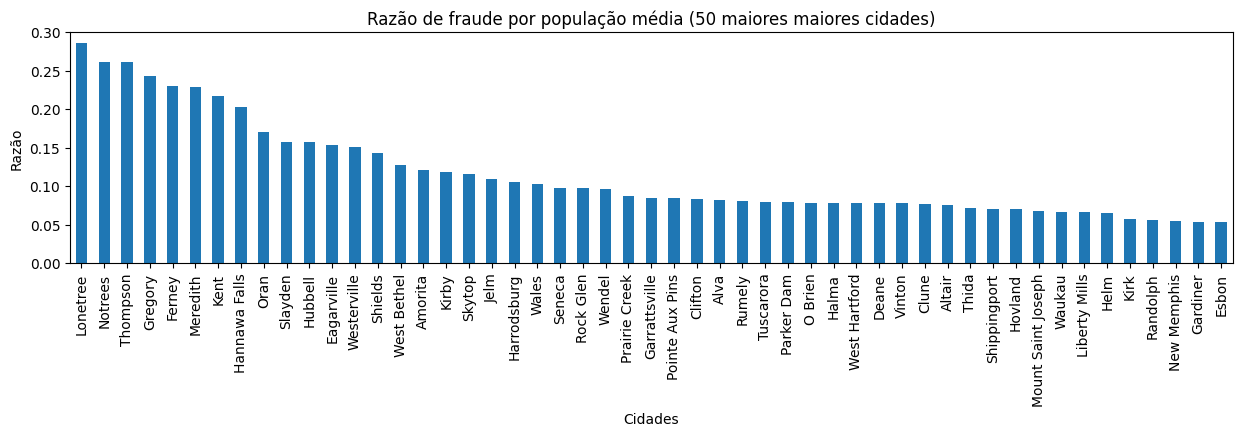

In [44]:
plt.figure(figsize=(15,3))
fraud_pop_ratio100.plot(kind="bar",
                        title="Razão de fraude por população média (50 maiores maiores cidades)",
                        xlabel="Cidades",
                        ylabel="Razão")

Vamos adicionar uma flag para essas cidades:

In [45]:
flag_city = lambda c: 1 if c in fraud_pop_ratio100.index else 0

df_train["flag_city"] = df_train["city"].apply(flag_city)
df_test["flag_city"] = df_test["city"].apply(flag_city)

### 1.3.9. Histórico de fraude

Vamos verificar as pessoas que mais realizaram fraudes estabelecendo a razão:

$$\frac{Número\ de\  transações\ fraudulentas}{Número\ de\ transações\ totais}$$

In [46]:
# Adicionando uma coluna de nome completo:
df_train["full_name"] = df_train["first"]+" "+df_train["last"]

# Vamos adicionar também no df_test porque precisaremos depois:
df_test["full_name"] = df_test["first"]+" "+df_test["last"]

# Calculando o número de transações totais e o número de transações fraudulentas por pessoa:
n_transacoes = df_train["full_name"].value_counts().sort_index()
n_transacoes_fraude = df_train[f_is_fraud]["full_name"].value_counts().sort_index()

# Construindo um dataframe para armazenar o número de transações por pessoa:

n_transacoes = pd.DataFrame(n_transacoes)
n_transacoes.reset_index(inplace=True)

n_transacoes_fraude = pd.DataFrame(n_transacoes_fraude)
n_transacoes_fraude.reset_index(inplace=True)

df_transacoes = n_transacoes.merge(n_transacoes_fraude, on='index', how='left')
df_transacoes.rename(columns={"index": "nome",
                              "full_name_x": "n_transacoes",
                              "full_name_y": "n_transacoes_fraude"},
                     inplace=True)

# Criando uma coluna para calular a razão de n_transacoes_fraude/n_transacoes em porcentagem:
df_transacoes["porcentagem_t_f"] = (df_transacoes["n_transacoes_fraude"]/df_transacoes["n_transacoes"])*100

# Ordenando com base em razao_t_f:
df_transacoes.sort_values(by="porcentagem_t_f", ascending=False, inplace=True)

# Selecionando clientes com alguma transação fraudulenta:
f_fraude = ~df_transacoes["porcentagem_t_f"].isnull()

# Visualizando:
df_transacoes[f_fraude]

,nome,n_transacoes,n_transacoes_fraude,porcentagem_t_f
486,Jose Jones,9,9.0,100.000000
131,Bryan Gill,8,8.0,100.000000
171,Christina Norris,7,7.0,100.000000
541,Kelly Lawrence,7,7.0,100.000000
552,Kevin Hawkins,15,15.0,100.000000
...,...,...,...,...
621,Margaret Curtis,3046,3.0,0.098490
830,Sara Harris,3055,3.0,0.098200
965,William Perry,2540,2.0,0.078740
454,Jessica Ward,3023,2.0,0.066159


Observamos que existem clientes que apresentam 100% de suas transações sendo fraudulentas.

Na verdade, como vemos abaixo, a maioria apresenta menos de 4% de suas transações sendo fraudadas.

In [47]:
df_transacoes["porcentagem_t_f"].value_counts().sort_index(ascending=False)

100.000000    72
3.891051       1
3.100775       1
3.042596       1
2.976190       2
              ..
0.098490       1
0.098200       1
0.078740       1
0.066159       1
0.064495       1
Name: porcentagem_t_f, Length: 600, dtype: int64

Vamos agora adicionar uma flag para os clientes que apresentaram 100% de transações fraudulentas no `df_train`:

In [48]:
# Selecionando o nome desses 100 clientes:
nome_fraudes_100 = df_transacoes[df_transacoes["porcentagem_t_f"]==100]["nome"].values

flag_name = lambda n: 1 if n in nome_fraudes_100 else 0
df_train["flag_name"] = df_train["full_name"].apply(flag_name)
df_test["flag_name"] = df_test["full_name"].apply(flag_name)

## 1.4. Correlações

In [49]:
# Selecionando colunas de interesse:

cols = [
  # "trans_date_trans_time",
  # "cc_num",
  # "merchant",
  "amt",
  # "first",
  # "last",
  # "street",
  # "city",
  # "state",
  # "zip",
  # "lat",
  # "long",
  # "city_pop",
  # "job",
  # "dob",
  # "trans_num",
  # "unix_time",
  # "merch_lat",
  # "merch_long",
  "is_fraud",
  # "month",        Removendo porque df_test não possuem meses com flag
  # "flag_month",   Removendo porque df_test não possuem meses com flag
  "hour",
  "flag_hour",
  "count_1_day",
  "count_7_days",
  "count_30_days",
  "time_diff",
  "category_entertainment",
  "category_food_dining",
  "category_gas_transport",
  "category_grocery_net",
  "category_grocery_pos",
  "category_health_fitness",
  "category_home",
  "category_kids_pets",
  "category_misc_net",
  "category_misc_pos",
  "category_personal_care",
  "category_shopping_net",
  "category_shopping_pos",
  "category_travel",
  # "gender_F",     Removendo porque o gênero não tem influência em transações fraudulentas
  # "gender_M",     Removendo porque o gênero não tem influência em transações fraudulentas
  "age",
  "distance_pm",
  "flag_city",
  # "full_name",
  # "flag_name",    Removendo porque df_test não possui nomes com flag
]

cols = np.array(cols)

<Axes: >

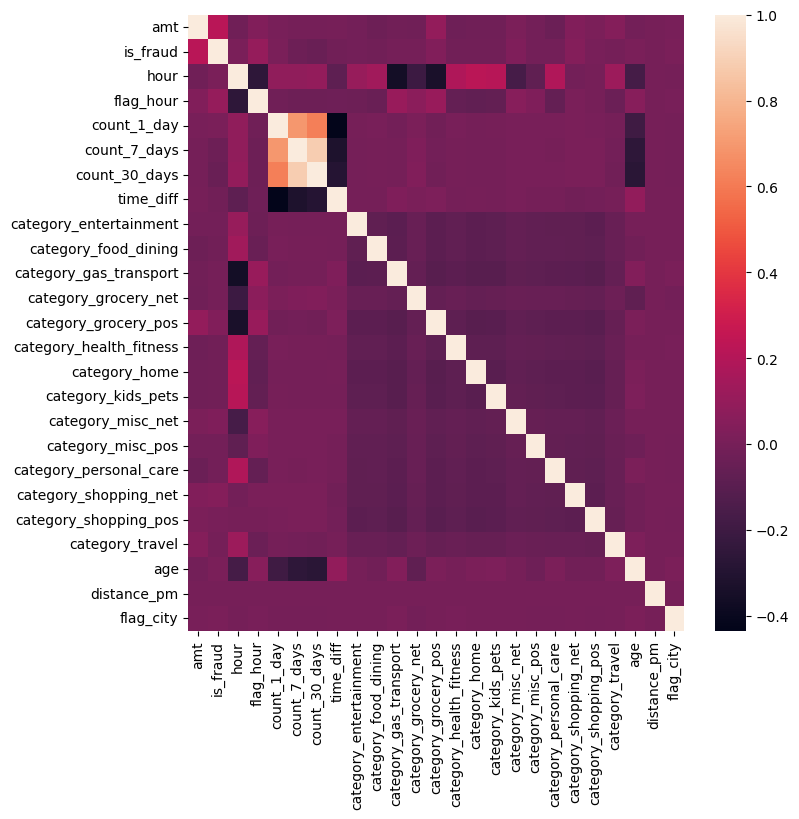

In [50]:
plt.figure(figsize=(8,8))
sns.heatmap(df_train[cols].corr())

<Axes: >

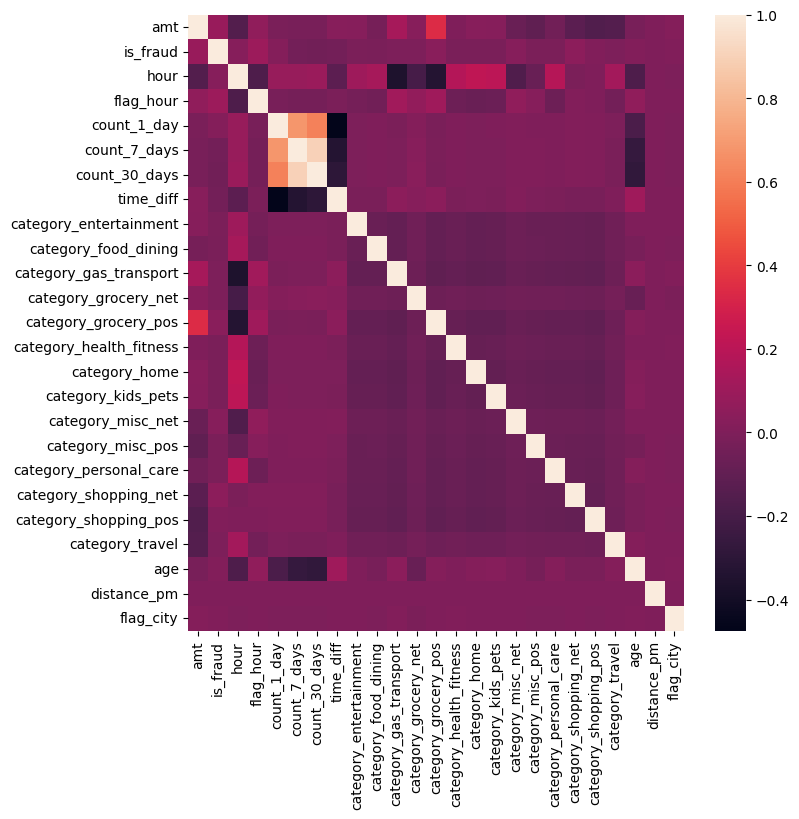

In [51]:
plt.figure(figsize=(8,8))
sns.heatmap(df_train[cols].corr(method = 'spearman'))

# 2. Detectando transações fraudulentas utilizando KNN

## 2.1. Separando e normalizando treino e teste

In [62]:
# Filtrando as colunas diferentes do nosso target:
f_cols = cols != "is_fraud"

# Separando as features (x) e o target (y):
x_train = df_train[cols[f_cols]]
x_test = df_test[cols[f_cols]]
y_train = df_train["is_fraud"]
y_test = df_test["is_fraud"]

# Normalizando:
scaler = MinMaxScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

## 2.2. Primeiro teste (n_neighbors = 3)

In [80]:
model = KNeighborsClassifier(n_neighbors = 3)
model

KNeighborsClassifier(n_neighbors=3)

In [64]:
# Fit do modelo (treinamento)
model.fit(x_train_norm, y_train)

KNeighborsClassifier(n_neighbors=3)

In [65]:
%%time
# Predições do modelo
y_pred = model.predict(x_test_norm)

CPU times: user 1h 48min 53s, sys: 7 s, total: 1h 49min
Wall time: 1h 5min 54s


Verificando a proporcionalidade dos dados de predição:

In [66]:
pd.Series(y_pred).value_counts(normalize = True)

0    0.998042
1    0.001958
dtype: float64

Lembrando que a proporção do dataset de teste é:

In [67]:
df_test["is_fraud"].value_counts(normalize = True)

0    0.99614
1    0.00386
Name: is_fraud, dtype: float64

Verificando em termos de quantidade:

In [68]:
print(f"Quantidade de fraudes em y_test: {y_test.values.sum()}")
print(f"Quantidade de fraudes em y_pred: {y_pred.sum()}")

Quantidade de fraudes em y_test: 2145
Quantidade de fraudes em y_pred: 1088


Printando as métricas desse modelo:

In [77]:
def evaluate_model(target, predicted):
  accuracy = accuracy_score(target, predicted)
  precision = precision_score(target, predicted)
  recall = recall_score(target, predicted)
  f1 = f1_score(target, predicted)

  print("Accuracy", accuracy.round(2))
  print("Precision:", precision.round(2))
  print("Recall:", recall.round(2))
  print("F1 Score", f1.round(2))

  cm = confusion_matrix(target, predicted)
  plot_confusion_matrix(conf_mat = cm, show_normed = True)

Accuracy 1.0
Precision: 0.59
Recall: 0.3
F1 Score 0.4


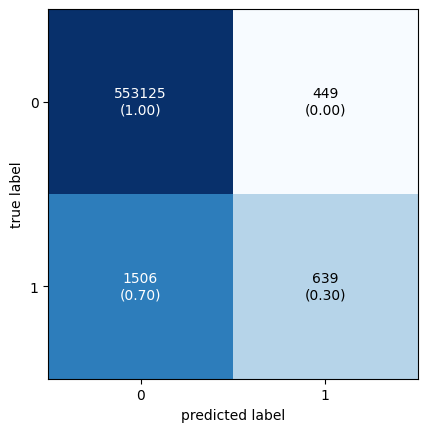

In [78]:
evaluate_model(y_test, y_pred)

**1. Accuracy (Acurácia) - 1.0:** A acurácia do modelo é de 100%. Isso significa que o modelo classificou corretamente todas as observações do conjunto de testes. No entanto, é raro (e às vezes suspeito) que um modelo tenha uma acurácia de 100%, especialmente em conjuntos de dados complexos ou desequilibrados. Uma acurácia muito alta pode ser um indicativo de sobreajuste ou simplesmente que o modelo está prevendo a classe majoritária na maioria das vezes devido ao desequilíbrio de classes.

**2. Precision (Precisão) - 0.59:** A precisão de 0.59 indica que, das transações que o modelo previu como fraudulentas, apenas 59% delas eram realmente fraudulentas. Os 41% restantes eram falsos positivos, ou seja, transações legítimas que foram erroneamente classificadas como fraudulentas.

**3. Recall (Sensibilidade) - 0.3:** O recall de 0.3 indica que o modelo detectou apenas 30% das transações fraudulentas reais. Isso significa que 70% das transações fraudulentas foram perdidas pelo modelo (falsos negativos). Em um contexto de detecção de fraudes, um recall baixo pode ser preocupante, pois indica que muitas fraudes estão passando despercebidas.

**4. F1 Score - 0.4:** O F1 Score é uma média harmônica entre precisão e recall. Ele busca um equilíbrio entre essas duas métricas. Um F1 Score de 0.4 sugere que nem a precisão nem o recall são particularmente altos, e o modelo pode precisar de melhorias para alcançar um desempenho mais equilibrado.

## 2.2. Segundo teste (n_neighbors = 8)

In [81]:
model8 = KNeighborsClassifier(n_neighbors = 8)
model8

KNeighborsClassifier(n_neighbors=8)

In [82]:
# Fit do modelo (treinamento)
model8.fit(x_train_norm, y_train)

KNeighborsClassifier(n_neighbors=8)

In [83]:
%%time
# Predições do modelo
y_pred8 = model8.predict(x_test_norm)

CPU times: user 1h 49min 3s, sys: 7.55 s, total: 1h 49min 11s
Wall time: 1h 9min 20s


Verificando a proporcionalidade dos dados de predição:

In [84]:
pd.Series(y_pred8).value_counts(normalize = True)

0    0.998825
1    0.001175
dtype: float64

Verificando em termos de quantidade:

In [85]:
print(f"Quantidade de fraudes em y_test: {y_test.values.sum()}")
print(f"Quantidade de fraudes em y_pred8: {y_pred8.sum()}")

Quantidade de fraudes em y_test: 2145
Quantidade de fraudes em y_pred8: 653


Printando as métricas desse modelo:

Accuracy 1.0
Precision: 0.82
Recall: 0.25
F1 Score 0.38


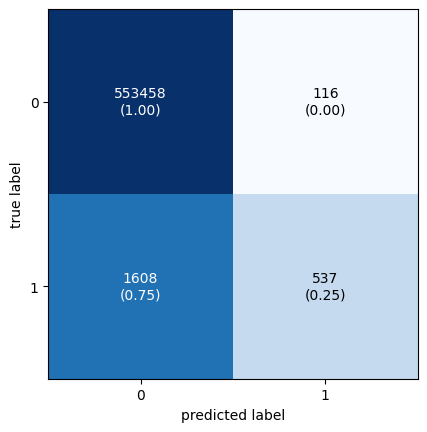

In [86]:
evaluate_model(y_test, y_pred8)

**1. Accuracy (Acurácia) - 1.0:** Novamente, a acurácia do modelo é de 100%. Isso indica que o modelo classificou corretamente todas as observações do conjunto de testes. Assim como antes, uma acurácia perfeita em conjuntos de dados complexos ou desequilibrados pode ser motivo de cautela. Pode indicar sobreajuste ou simplesmente que o modelo está prevendo a classe majoritária na maioria das vezes devido ao desequilíbrio de classes.

**2. Precision (Precisão) - 0.82:** A precisão de 0.82 é uma melhoria em relação ao modelo anterior. Isso indica que, das transações que o modelo previu como fraudulentas, 82% delas eram realmente fraudulentas. Os 18% restantes eram falsos positivos. Isso sugere que o modelo tornou-se mais confiável ao sinalizar transações como fraudulentas, comparado ao modelo anterior com `n_neighbors = 3`.

**3. Recall (Sensibilidade) - 0.25:** O recall de 0.25 é um pouco menor do que o modelo anterior. Isso significa que o modelo só detectou 25% das transações fraudulentas reais, deixando 75% delas passarem como transações legítimas. Em contextos de detecção de fraudes, um recall baixo pode ser um ponto crítico, pois indica muitas fraudes não detectadas.

**4. F1 Score - 0.38:** O F1 Score é ligeiramente menor em comparação com o modelo anterior, indicando que o equilíbrio entre precisão e recall não melhorou, apesar do aumento na precisão.

#3. Conclusões gerais



* A **alta acurácia** (100%) em contraste com a **precisão**, **recall** e **F1 Score** mais baixos sugere que o conjunto de dados pode estar muito desequilibrado, o que se verifica, uma vez que existem poucas fraudes em comparação com transações legítimas. Nesse caso, mesmo que os modelos prevejam que todas as transações são legítimas, ainda podem alcançar uma acurácia muito alta. Isso destaca por que a acurácia, por si só, pode ser enganosa em conjuntos de dados desequilibrados.

* O **recall baixo** representa uma preocupação. Em contextos como detecção de fraudes, você pode querer priorizar um recall mais alto, mesmo que isso signifique sacrificar um pouco a precisão. Falsos negativos (fraudes não detectadas) podem ter consequências mais graves do que falsos positivos.

* A **baixa precisão** em ambos os casos sugere que ainda há espaço para melhorar a capacidade do modelo de evitar falsos positivos.

* Em geral, **é possível que o KNN não seja o melhor modelo para este problema** ou que precise de mais ajustes.
  * De fato, tentamos otimiza-lo através do método `GridSearch()`, entretanto, pelas iterações de cada predição serem muito lentas (com quase 1h de processamento cada), excedemos o limite de uso do Google Colab, o que inviabilizou tal melhoria.

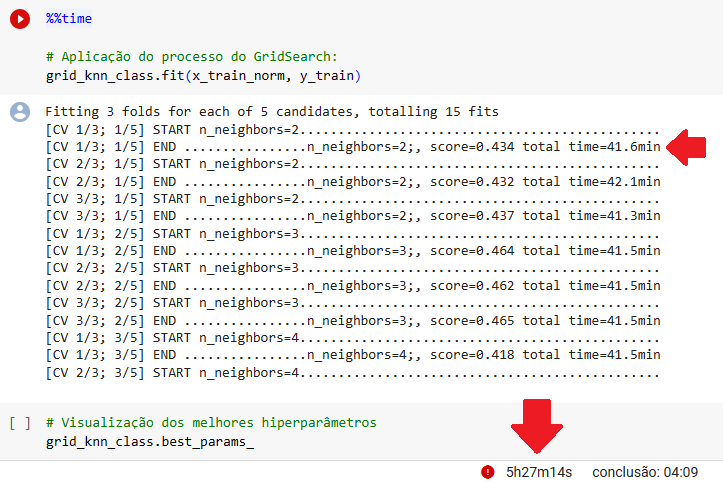

# 4. Grid Search

Não conseguimos executar as células abaixo em tempo hábil para obtermos um melhor desempenho dos nossos modelos.

In [ ]:
model.get_params()

In [ ]:
# Definição da estrutura de validação cruzada:
splitter = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Definição da métrica de avaliação do estimador:
metrica = "f1"

# Durante nossa procura dos melhores hiperparâmetros, vamos enfocar o número de vizinhos:
param_grid = {"n_neighbors": range(2,16)}

# Definição do estimador
KNN = KNeighborsClassifier()

# Grid search
grid_knn_class = GridSearchCV(estimator = KNN,
                              param_grid = param_grid,
                              scoring = metrica,
                              cv = splitter,
                              # n_jobs = -1,
                              verbose=10)

In [ ]:
grid_knn_class

In [ ]:
%%time

# Aplicação do processo do GridSearch:
grid_knn_class.fit(x_train_norm, y_train)

In [ ]:
# Visualização dos melhores hiperparâmetros
grid_knn_class.best_params_